<a href="https://colab.research.google.com/github/abhinavbhatia5/celestialClassification/blob/main/ads_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Sanity Check #

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

You can check the output of `!nvidia-smi` to check which GPU you have.  Please uncomment the cell below if you'd like to do that.  Currently, RAPIDS runs on all available Colab GPU instances.

In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py


Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 476, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 476 (delta 141), reused 124 (delta 91), pack-reused 269
Receiving objects: 100% (476/476), 131.59 KiB | 5.72 MiB/s, done.
Resolving deltas: 100% (243/243), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.1 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has a Tesla T4 GPU!
We will install the latest stable RAPIDS via pip 24.4.*!  Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.3/473.3 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 GB 831.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cuml

In [ ]:
import cupy as cp
import cudf as cd
import pandas as pd
import numpy as np

In [ ]:
# data= cd.read_csv("/content/drive/MyDrive/Classroom/UCS622: Conversational AI: Accelerated Data Science [Advanced]/star_classification.csv")
data= cd.read_csv("/content/SkyServerDataset.csv")

In [ ]:
data.head()

,obj_ID,ra,dec,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237660e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543780e+18,GALAXY,0.634794,5812,56354,171
1,1.237660e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176010e+19,GALAXY,0.779136,10445,58158,427
2,1.237660e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237660e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030110e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891860e+18,GALAXY,0.116123,6121,56187,842


In [ ]:
data.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   obj_ID       100000 non-null  float64
 1   ra           100000 non-null  float64
 2   dec          100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64
 9   rerun_ID     100000 non-null  int64
 10  cam_col      100000 non-null  int64
 11  field_ID     100000 non-null  int64
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64
 16  MJD          100000 non-null  int64
 17  fiber_ID     100000 non-null  int64
dtypes: float64(10), int64(7), object(1)
memory

In [ ]:
data = data.drop(['obj_ID'],axis=1)
data = data.drop(['rerun_ID'],axis=1)
data.drop_duplicates()
data

,ra,dec,u,g,r,i,z,run_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,2,79,6.543780e+18,GALAXY,0.634794,5812,56354,171
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,5,119,1.176010e+19,GALAXY,0.779136,10445,58158,427
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,3,214,1.030110e+19,GALAXY,0.932346,9149,58039,775
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,3,137,6.891860e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,2,581,1.060000e+19,GALAXY,0.000000,9374,57749,438
99996,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,1,289,8.586350e+18,GALAXY,0.404895,7626,56934,866
99997,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,4,308,3.112010e+18,GALAXY,0.143366,2764,54535,74
99998,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470


In [ ]:
data.isnull().sum()

ra             0
dec            0
u              0
g              0
r              0
i              0
z              0
run_ID         0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

In [ ]:

cols = ['run_ID', 'ra', 'dec']

# Convert columns to numeric, coercing errors to NaN
for col in cols:
    data[col] = data[col].astype('float64').fillna(-1)

# Fill NaN values with mean, median, and std respectively
data['run_ID'] = data['run_ID'].replace(-1, data['run_ID'].mean())
data['ra'] = data['ra'].replace(-1, data['ra'].median())
data['dec'] = data['dec'].replace(-1, data['dec'].std())



In [ ]:
data

,ra,dec,u,g,r,i,z,run_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606.0,2,79,6.543780e+18,GALAXY,0.634794,5812,56354,171
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518.0,5,119,1.176010e+19,GALAXY,0.779136,10445,58158,427
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606.0,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192.0,3,214,1.030110e+19,GALAXY,0.932346,9149,58039,775
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102.0,3,137,6.891860e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778.0,2,581,1.060000e+19,GALAXY,0.000000,9374,57749,438
99996,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917.0,1,289,8.586350e+18,GALAXY,0.404895,7626,56934,866
99997,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314.0,4,308,3.112010e+18,GALAXY,0.143366,2764,54535,74
99998,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650.0,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470


In [ ]:
data.isnull().sum()

ra             0
dec            0
u              0
g              0
r              0
i              0
z              0
run_ID         0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

In [ ]:
data = data.drop(columns=['spec_obj_ID'])


In [ ]:
data.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   ra        100000 non-null  float64
 1   dec       100000 non-null  float64
 2   u         100000 non-null  float64
 3   g         100000 non-null  float64
 4   r         100000 non-null  float64
 5   i         100000 non-null  float64
 6   z         100000 non-null  float64
 7   run_ID    100000 non-null  float64
 8   cam_col   100000 non-null  int64
 9   field_ID  100000 non-null  int64
 10  class     100000 non-null  object
 11  redshift  100000 non-null  float64
 12  plate     100000 non-null  int64
 13  MJD       100000 non-null  int64
 14  fiber_ID  100000 non-null  int64
dtypes: float64(9), int64(5), object(1)
memory usage: 11.5+ MB


In [ ]:
import matplotlib.pyplot as plt
pdf = data.to_pandas()


In [ ]:
pdf

,ra,dec,u,g,r,i,z,run_ID,cam_col,field_ID,class,redshift,plate,MJD,fiber_ID
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606.0,2,79,GALAXY,0.634794,5812,56354,171
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518.0,5,119,GALAXY,0.779136,10445,58158,427
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606.0,2,120,GALAXY,0.644195,4576,55592,299
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192.0,3,214,GALAXY,0.932346,9149,58039,775
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102.0,3,137,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778.0,2,581,GALAXY,0.000000,9374,57749,438
99996,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917.0,1,289,GALAXY,0.404895,7626,56934,866
99997,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314.0,4,308,GALAXY,0.143366,2764,54535,74
99998,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650.0,4,131,GALAXY,0.455040,6751,56368,470


<Axes: >

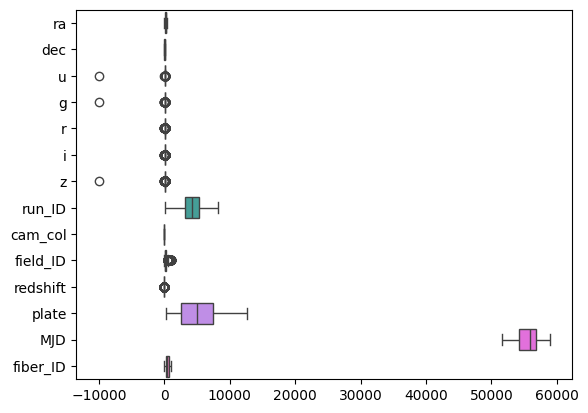

In [ ]:
import seaborn as sns
sns.boxplot(pdf,orient='h')


<Axes: ylabel='r'>

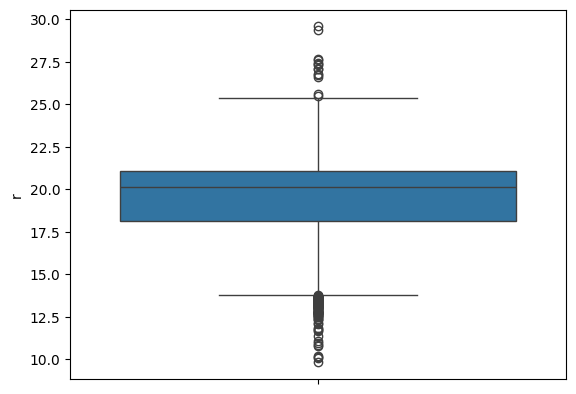

In [ ]:
sns.boxplot(pdf['r'])

In [ ]:
pdf.iloc[:,:-1]

,ra,dec,u,g,r,i,z,run_ID,cam_col,field_ID,class,redshift,plate,MJD
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606.0,2,79,GALAXY,0.634794,5812,56354
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518.0,5,119,GALAXY,0.779136,10445,58158
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606.0,2,120,GALAXY,0.644195,4576,55592
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192.0,3,214,GALAXY,0.932346,9149,58039
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102.0,3,137,GALAXY,0.116123,6121,56187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778.0,2,581,GALAXY,0.000000,9374,57749
99996,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917.0,1,289,GALAXY,0.404895,7626,56934
99997,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314.0,4,308,GALAXY,0.143366,2764,54535
99998,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650.0,4,131,GALAXY,0.455040,6751,56368


In [ ]:
# Assuming 'data' is your DataFrame
# data_without_class = pdf.drop('class', axis=1)

from scipy import stats
#Removing outliers Z-score
z_threshold=3

z_scores = np.abs(stats.zscore(pdf.iloc[:, pdf.columns != 'class']))

# Create a mask to identify outliers
outlier_mask = (z_scores > z_threshold).any(axis=1)
outlier_mask

# Remove rows with outliers
df_no_outliers = pdf[~outlier_mask]

# Display the DataFrame with outliers removed
print(df_no_outliers)

               ra        dec         u         g         r         i  \
0      135.689107  32.494632  23.87882  22.27530  20.39501  19.16573   
1      144.826101  31.274185  24.77759  22.83188  22.58444  21.16812   
2      142.188790  35.582444  25.26307  22.66389  20.60976  19.34857   
3      338.741038  -0.402828  22.13682  23.77656  21.61162  20.50454   
4      345.282593  21.183866  19.43718  17.58028  16.49747  15.97711   
...           ...        ...       ...       ...       ...       ...   
99995   39.620709  -2.594074  22.16759  22.97586  21.90404  21.30548   
99996   29.493819  19.798874  22.69118  22.38628  20.45003  19.75759   
99997  224.587407  15.700707  21.16916  19.26997  18.20428  17.69034   
99998  212.268621  46.660365  25.35039  21.63757  19.91386  19.07254   
99999  196.896053  49.464643  22.62171  21.79745  20.60115  20.00959   

              z  run_ID  cam_col  field_ID   class  redshift  plate    MJD  \
0      18.79371  3606.0        2        79  GALAXY  0.634

In [ ]:
df_no_outliers.head()

,ra,dec,u,g,r,i,z,run_ID,cam_col,field_ID,class,redshift,plate,MJD,fiber_ID
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606.0,2,79,GALAXY,0.634794,5812,56354,171
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518.0,5,119,GALAXY,0.779136,10445,58158,427
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606.0,2,120,GALAXY,0.644195,4576,55592,299
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192.0,3,214,GALAXY,0.932346,9149,58039,775
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102.0,3,137,GALAXY,0.116123,6121,56187,842


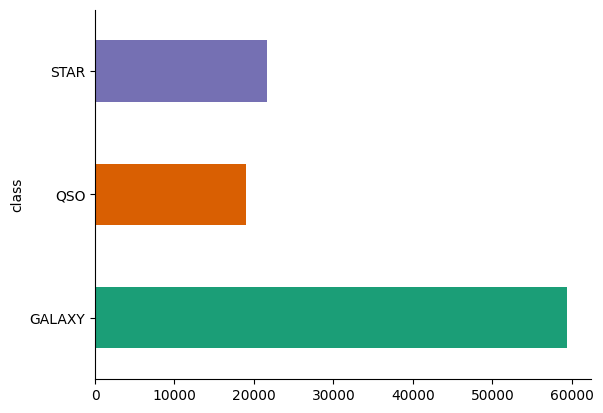

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
pdf.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

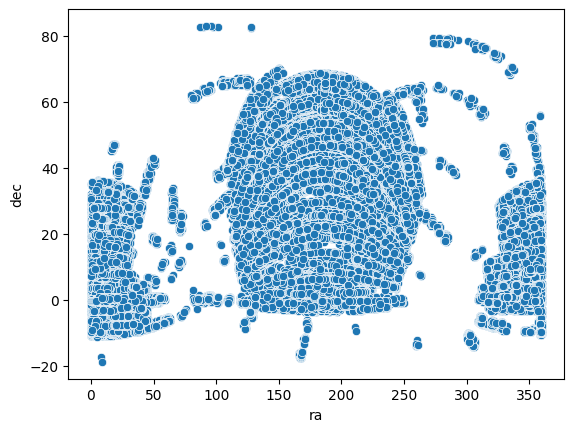

In [ ]:
sns.scatterplot(x = df_no_outliers.ra, y = df_no_outliers.dec)
plt.show()

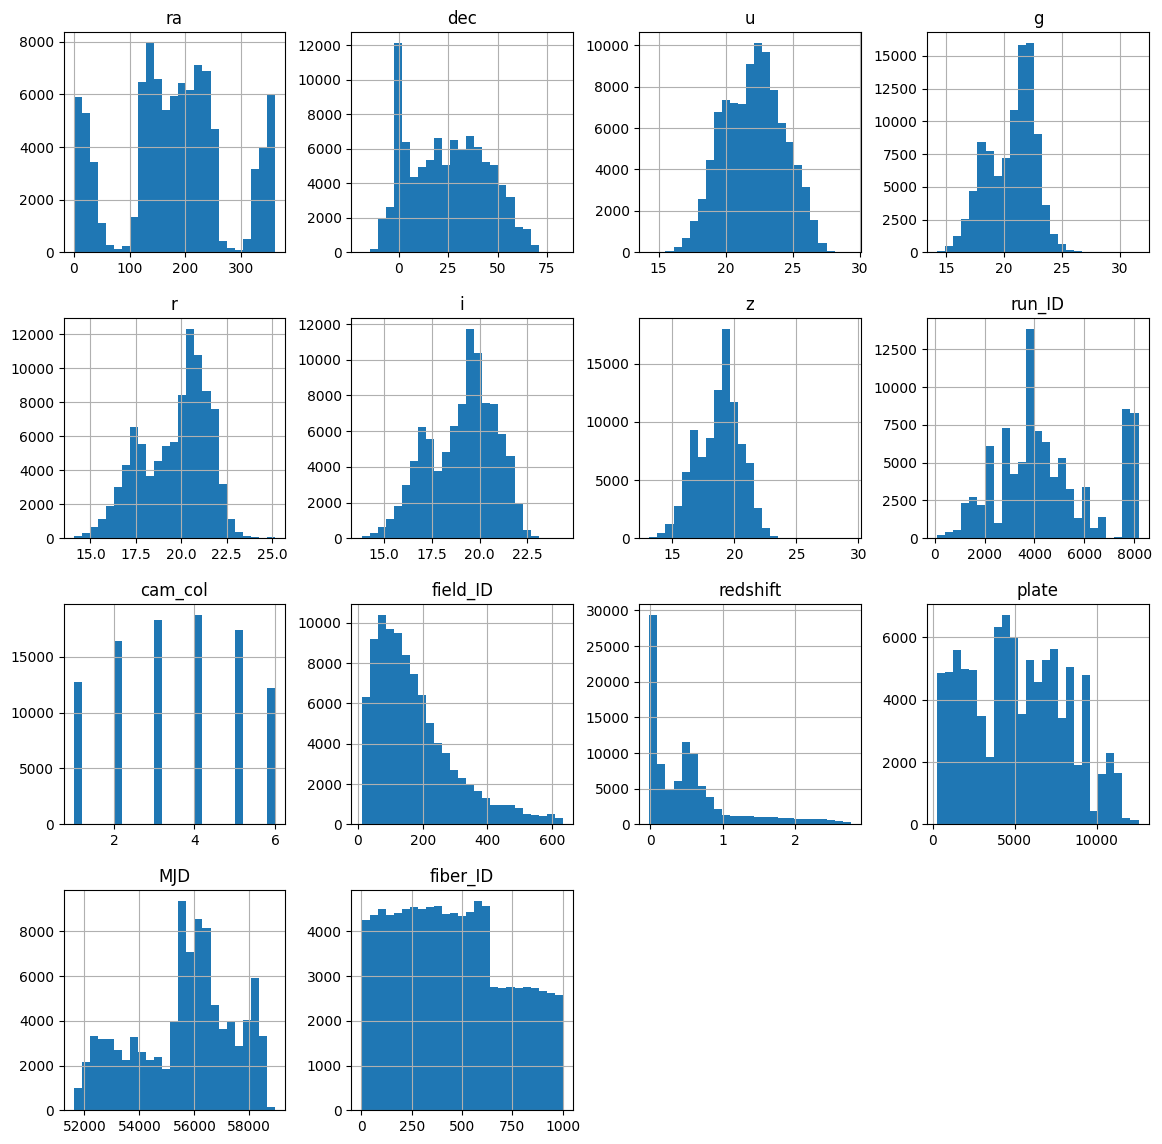

In [ ]:
df_no_outliers.hist(bins =25 , figsize= (14,14))
plt.show()

In [ ]:
data_no_outliers=cd.DataFrame.from_pandas(df_no_outliers)
from cuml import preprocessing
LE = preprocessing.LabelEncoder()
data_no_outliers['class'] = LE.fit_transform(data_no_outliers['class'])

In [ ]:
distinct= data_no_outliers['class'].value_counts()
distinct

class
0    57765
2    21017
1    16975
Name: count, dtype: int64

In [ ]:
X = data_no_outliers[['u', 'g', 'r', 'i', 'z', 'redshift', 'plate']]
X

,u,g,r,i,z,redshift,plate
0,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,5812
1,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,10445
2,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,4576
3,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,9149
4,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,6121
...,...,...,...,...,...,...,...
99995,22.16759,22.97586,21.90404,21.30548,20.73569,0.000000,9374
99996,22.69118,22.38628,20.45003,19.75759,19.41526,0.404895,7626
99997,21.16916,19.26997,18.20428,17.69034,17.35221,0.143366,2764
99998,25.35039,21.63757,19.91386,19.07254,18.62482,0.455040,6751


In [ ]:
y = data_no_outliers['class']
y

0        0
1        0
2        0
3        0
4        0
        ..
99995    0
99996    0
99997    0
99998    0
99999    0
Name: class, Length: 95757, dtype: uint8

RESAMPLING

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 30, k_neighbors = 5)
X_res, y_res = sm.fit_resample(X.to_pandas(), y.to_pandas())

Preprocessing using StandardScaler()

In [ ]:
ss=preprocessing.StandardScaler()
X_res=ss.fit_transform(X_res)
X_res=cd.DataFrame.from_pandas(X_res)
X_res.head()

/usr/local/lib/python3.10/dist-packages/cupy/cuda/compiler.py:233: PerformanceWarning: Jitify is performing a one-time only warm-up to populate the persistent cache, this may take a few seconds and will be improved in a future release...
  jitify._init_module()


,0,1,2,3,4,5,6
0,1.038085,0.939455,0.369809,-0.072506,-0.137011,-0.024119,0.122393
1,1.467164,1.231454,1.595425,1.082037,1.471459,0.170388,1.656614
2,1.698936,1.143321,0.490023,0.032916,-0.048871,-0.011451,-0.286909
3,0.206441,1.727061,1.050852,0.699428,0.123253,0.376844,1.227443
4,-1.082387,-1.523695,-1.811986,-1.911008,-1.989863,-0.723048,0.224719


In [ ]:
y_res.value_counts()

class
0    57765
1    57765
2    57765
Name: count, dtype: int64

In [ ]:
y_res=cd.Series.from_pandas(y_res)

In [ ]:
import cuml
from cuml import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state = 30)

Algorithms

In [ ]:
# Creating the dataframe in which we'll store the accuracy scores of all the classification algorithms so we can choose the best one.
acc_score = cd.DataFrame(columns=['Algorithm', 'cuml_accuracy', 'cuml_r2_score'])

In [ ]:
acc_score

,Algorithm,cuml_accuracy,cuml_r2_score


1. Logistic Regression Model

In [ ]:
from cuml import make_regression
from cuml.linear_model import LogisticRegression as cuLogisticRegression
from cuml.metrics.regression import r2_score
from sklearn.linear_model import LogisticRegression as skLogsiticRegression


In [ ]:
model = cuLogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred1 = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
from cupy import asnumpy
cu_score = cuml.metrics.accuracy_score( y_test, y_pred1 )
y_test_float32 = y_test.astype('float32')
cu_r2_1= cuml.metrics.r2_score( y_test_float32, y_pred1)

In [ ]:
new_row = cd.DataFrame({'Algorithm': ['LogisticRegression'],
                          'cuml_accuracy': [cu_score],
                          'cuml_r2_score': [cu_r2_1]})
acc_score = cd.concat([acc_score, new_row], ignore_index=True)
print(acc_score)

            Algorithm  cuml_accuracy  cuml_r2_score
0  LogisticRegression       0.958959       0.898732


In [ ]:
from cuml.metrics import confusion_matrix
y_test_int32 = y_test.astype('int32')
y_pred_lr_int32 = y_pred1.astype('int32')

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_int32, y_pred_lr_int32)

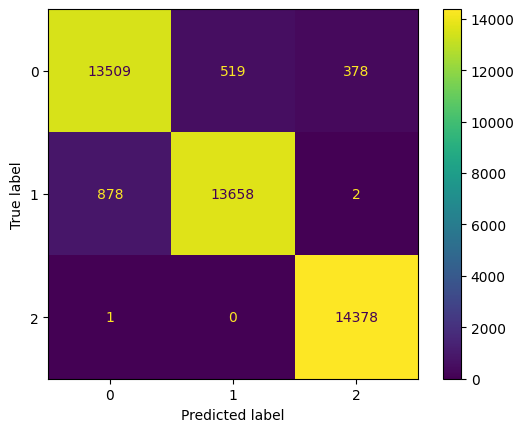

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix.get(),
display_labels=model.classes_.to_pandas())
disp.plot()

2. KNN

In [ ]:
knn_df = cd.DataFrame(columns=['Neighbors','CumlScore'])

In [ ]:
import cuml
from cuml.neighbors import KNeighborsClassifier

# Assuming X_train, X_test, y_train are cuDF DataFrames
# Convert cuDF DataFrames to cuML DataFrames
X_train_cuml = cd.DataFrame.from_pandas(X_train)
X_test_cuml = cd.DataFrame.from_pandas(X_test)
y_train_cuml = cd.Series(y_train)

for i in range(1, 21):
    model = KNeighborsClassifier(n_neighbors=i)

    model.fit(X_train_cuml, y_train_cuml)
    y_pred2 = model.predict(X_test_cuml)
    knn_newrow= cd.DataFrame({'Neighbors':i, 'CumlScore':cuml.metrics.accuracy_score( y_test, y_pred2),},index=[1])
    knn_df = cd.concat([knn_df, knn_newrow])
knn_df


,Neighbors,CumlScore
1,1,0.966046
1,2,0.962006
1,3,0.966715
1,4,0.965907
1,5,0.965815
1,6,0.965723
1,7,0.964776
1,8,0.964361
1,9,0.963507
1,10,0.963437


In [ ]:
knn_df = knn_df.sort_values(by='CumlScore', ascending = False)
knn_df.head()

,Neighbors,CumlScore
1,3,0.966715
1,1,0.966046
1,4,0.965907
1,5,0.965815
1,6,0.965723


In [ ]:
from cuml.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors = 3)
model.fit(X_train_cuml, y_train_cuml)
y_pred2 = model.predict(X_test_cuml)

from sklearn.metrics import accuracy_score
from cupy import asnumpy
cu_score_knn = cuml.metrics.accuracy_score( y_test, y_pred2)
y_test_float32 = y_test.astype('float32')
cu_r2_knn= cuml.metrics.r2_score( y_test_float32, y_pred2)

In [ ]:
new_row1 = cd.DataFrame({'Algorithm': ['KNN'],
                          'cuml_accuracy': [cu_score_knn],
                          'cuml_r2_score': [cu_r2_knn]})
acc_score = cd.concat([acc_score, new_row1], ignore_index=True)
print(acc_score)

            Algorithm  cuml_accuracy  cuml_r2_score
0  LogisticRegression       0.958959       0.898732
1                 KNN       0.966715       0.890394


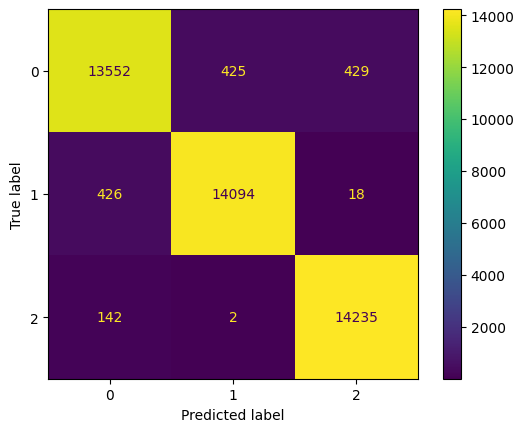

In [ ]:
y_test_int32 = y_test.astype('int32')
y_pred2_int32 = y_pred2.astype('int32')
from cuml.metrics import confusion_matrix as cucm
# Compute confusion matrix
conf_matrix = cucm(y_test_int32, y_pred2_int32)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix.get(),
display_labels=model.classes_.to_pandas())
disp.plot()

3. SVM Classifier

In [ ]:
from cuml.svm import SVC
model_svc=SVC()
model_svc.fit(X_train_cuml, y_train_cuml)
y_pred_svc=model_svc.predict(X_test_cuml)

In [ ]:
cu_score_svc = cuml.metrics.accuracy_score( y_test, y_pred_svc)
y_test_float32 = y_test.astype('float32')
cu_r2_svc= cuml.metrics.r2_score( y_test_float32, y_pred_svc)

In [ ]:
new_row1 = cd.DataFrame({'Algorithm': ['SVM'],
                          'cuml_accuracy': [cu_score_svc],
                          'cuml_r2_score': [cu_r2_svc]})
acc_score = cd.concat([acc_score, new_row1], ignore_index=True)
print(acc_score)

            Algorithm  cuml_accuracy  cuml_r2_score
0  LogisticRegression       0.958959       0.898732
1                 KNN       0.966715       0.890394
2                 SVM       0.971055       0.923502


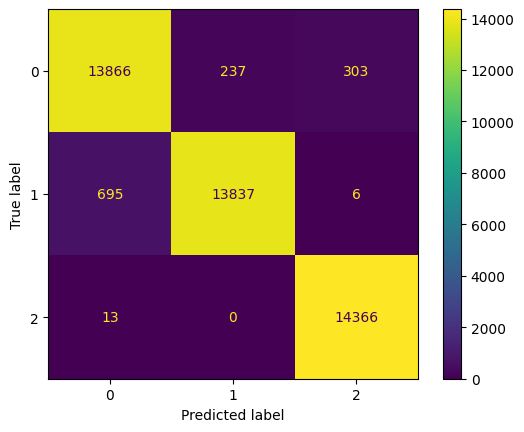

In [ ]:
y_test_int32 = y_test.astype('int32')
y_pred_svc_int32 = y_pred_svc.astype('int32')
from cuml.metrics import confusion_matrix as cucm
# Compute confusion matrix
conf_matrix = cucm(y_test_int32, y_pred_svc_int32)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix.get(),
display_labels=model.classes_.to_pandas())
disp.plot()

4. XGBoost

In [ ]:
import xgboost as xgb
model = xgb.XGBClassifier(random_state = 30,device='cuda')
model.fit(X_train.to_pandas(), y_train.to_pandas())
y_pred6 = model.predict(X_test.to_pandas())


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [19:10:15] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [ ]:
cu_score_xg=cuml.metrics.accuracy_score(y_test.to_pandas(),y_pred6)
y_test_float32 = y_test.astype('float32')
cu_r2_xg= cuml.metrics.r2_score( y_test_float32, y_pred6)

In [ ]:
new_row1 = cd.DataFrame({'Algorithm': ['XGBoost'],
                          'cuml_accuracy': [cu_score_xg],
                          'cuml_r2_score': [cu_r2_xg]})
acc_score = cd.concat([acc_score, new_row1], ignore_index=True)
print(acc_score)

            Algorithm  cuml_accuracy  cuml_r2_score
0  LogisticRegression       0.958959       0.898732
1                 KNN       0.966715       0.890394
2                 SVM       0.971055       0.923502
3             XGBoost       0.979988       0.961959


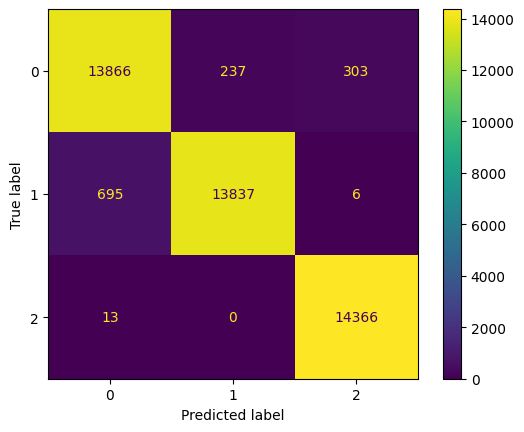

In [ ]:
y_test_int32_xg = y_test.astype('int32')
y_pred_int32_xg = y_pred6.astype('int32')
from cuml.metrics import confusion_matrix as cucm
# Compute confusion matrix
conf_matrix_xg = cucm(y_test_int32_xg, y_pred_int32_xg)
disp_xg = ConfusionMatrixDisplay(confusion_matrix=conf_matrix.get(),
display_labels=model.classes_)
disp_xg.plot()

5. ANN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# Create the neural network model
model = Sequential()
model.add(Dense(128, input_dim=X_train_cuml.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Assuming y_train is your training labels
num_classes = len(np.unique(y_train))


In [ ]:
import os
import numpy as np
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Assuming you want to use GPU device 0

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# Assuming X_train_cuml and y_train are your training data and labels respectively
# Convert cuDF or cuML GPU arrays to NumPy arrays
X_train_numpy = X_train_cuml.to_numpy()
y_train_numpy = y_train.to_numpy()

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Create the neural network model
model = Sequential()
model.add(Dense(128, input_dim=X_train_numpy.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
# Modify this layer to match the number of classes in your classification problem
model.add(Dense(num_classes, activation='softmax'))  # Assuming num_classes is the number of output classes

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Assuming y_train is your training labels
# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_numpy)

# Train the model
model.fit(X_train_numpy, y_train_one_hot, epochs=10, batch_size=32)

# Once the model is trained, you can use it for prediction
# For prediction, you need to ensure that your input data is in the same format as your training data
# Assuming X_test_cuml is your test data
# Convert test data to NumPy array if necessary
# X_test_numpy = X_test_cuml.to_numpy()
# y_pred = model.predict(X_test_numpy)




Num GPUs Available:  1
Epoch 1/10
4062/4062 [==============================] - 16s 3ms/step - loss: 0.1456 - accuracy: 0.9511
Epoch 2/10
4062/4062 [==============================] - 13s 3ms/step - loss: 0.1035 - accuracy: 0.9665
Epoch 3/10
4062/4062 [==============================] - 13s 3ms/step - loss: 0.0981 - accuracy: 0.9686
Epoch 4/10
4062/4062 [==============================] - 13s 3ms/step - loss: 0.0951 - accuracy: 0.9697
Epoch 5/10
4062/4062 [==============================] - 13s 3ms/step - loss: 0.0908 - accuracy: 0.9707
Epoch 6/10
4062/4062 [==============================] - 13s 3ms/step - loss: 0.0887 - accuracy: 0.9715
Epoch 7/10
4062/4062 [==============================] - 13s 3ms/step - loss: 0.0882 - accuracy: 0.9723
Epoch 8/10
4062/4062 [==============================] - 13s 3ms/step - loss: 0.0871 - accuracy: 0.9720
Epoch 9/10
4062/4062 [==============================] - 13s 3ms/step - loss: 0.0850 - accuracy: 0.9729
Epoch 10/10
4062/4062 [===========================

In [ ]:
X_test_numpy = X_test.to_numpy()
y_pred_ann= model.predict(X_test_numpy)




1354/1354 [==============================] - 3s 2ms/step


In [ ]:
y_pred_classes = y_pred_ann.argmax(axis=-1)
y_pred_classes

array([0, 1, 2, ..., 2, 2, 0])

In [ ]:
cu_score_ann =cuml.metrics.accuracy_score(y_test.to_numpy(),y_pred_classes)
y_test_float32 = y_test.astype('float32')
cu_r2_ann= cuml.metrics.r2_score( y_test_float32, y_pred_classes)

In [ ]:
new_row1 = cd.DataFrame({'Algorithm': ['ANN'],
                          'cuml_accuracy': [cu_score_ann],
                          'cuml_r2_score': [cu_r2_ann]})
acc_score = cd.concat([acc_score, new_row1], ignore_index=True)
print(acc_score)

            Algorithm  cuml_accuracy  cuml_r2_score
0  LogisticRegression       0.958959       0.898732
1                 KNN       0.966715       0.890394
2                 SVM       0.971055       0.923502
3             XGBoost       0.979988       0.961959
4                 ANN       0.969508       0.906479


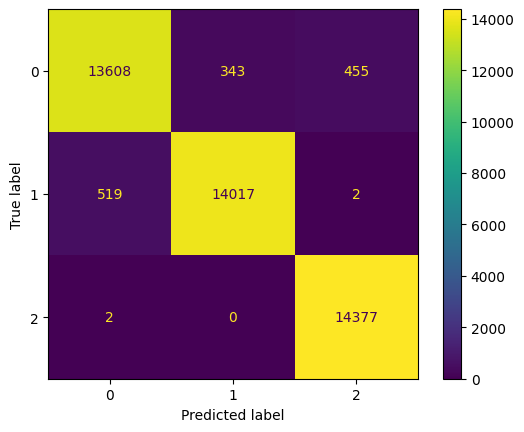

In [ ]:
y_test_int32 = y_test.astype('int32')
y_pred_int32 = y_pred_classes.astype('int32')
from cuml.metrics import confusion_matrix as cucm
# Compute confusion matrix
conf_matrix = cucm(y_test_int32, y_pred_int32)
# disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix.get(),
# display_labels=model.classes_.to_pandas())
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix.get())
disp.plot()

6. Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state = 30)
model.fit(X_train.to_pandas(), y_train.to_pandas())
y_pred_dt = model.predict(X_test.to_pandas())

In [ ]:
cu_score_dt=cuml.metrics.accuracy_score(y_test.to_pandas(),y_pred_dt)
y_test_float32 = y_test.astype('float32')
cu_r2_dt= cuml.metrics.r2_score( y_test_float32, y_pred_dt)

In [ ]:
new_row1 = cd.DataFrame({'Algorithm': ['Decision Tree'],
                          'cuml_accuracy': [cu_score_dt],
                          'cuml_r2_score': [cu_r2_dt]})
acc_score = cd.concat([acc_score, new_row1], ignore_index=True)
print(acc_score)

            Algorithm  cuml_accuracy  cuml_r2_score
0  LogisticRegression       0.958959       0.898732
1                 KNN       0.966715       0.890394
2                 SVM       0.971055       0.923502
3             XGBoost       0.979988       0.961959
4                 ANN       0.969508       0.906479
5       Decision Tree       0.970408       0.950669


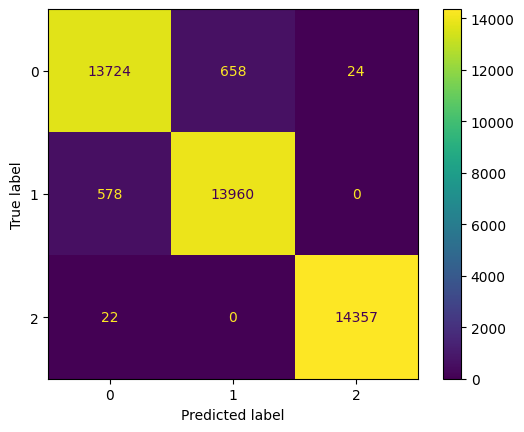

In [ ]:
y_test_int32 = y_test.astype('int32')
y_pred_int32 = y_pred_dt.astype('int32')
from cuml.metrics import confusion_matrix as cucm
# Compute confusion matrix
conf_matrix = cucm(y_test_int32, y_pred_int32)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix.get(),
display_labels=model.classes_)

disp.plot()

7. Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train.to_pandas(), y_train.to_pandas())
y_pred_nb = model.predict(X_test.to_pandas())

In [ ]:
cu_score_nb= cuml.metrics.accuracy_score(y_test.to_pandas(),y_pred_nb)
y_test_float32 = y_test.astype('float32')
cu_r2_nb= cuml.metrics.r2_score( y_test_float32, y_pred_nb )

In [ ]:
new_row1 = cd.DataFrame({'Algorithm': ['Gaussian Naive Bayes'],
                          'cuml_accuracy': [cu_score_nb],
                          'cuml_r2_score': [cu_r2_nb]})
acc_score = cd.concat([acc_score, new_row1], ignore_index=True)
print(acc_score)

              Algorithm  cuml_accuracy  cuml_r2_score
0    LogisticRegression       0.958959       0.898732
1                   KNN       0.966715       0.890394
2                   SVM       0.971055       0.923502
3               XGBoost       0.979988       0.961959
4                   ANN       0.969508       0.906479
5         Decision Tree       0.970408       0.950669
6  Gaussian Naive Bayes       0.926252       0.871183


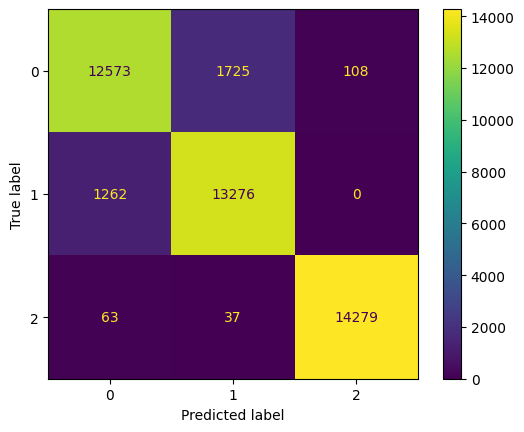

In [ ]:
y_test_int32 = y_test.astype('int32')
y_pred_int32 = y_pred_nb.astype('int32')
from cuml.metrics import confusion_matrix as cucm
# Compute confusion matrix
conf_matrix = cucm(y_test_int32, y_pred_int32)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix.get(),
display_labels=model.classes_)

disp.plot()

8. Random Forest

In [ ]:
rf_df = cd.DataFrame(columns=['Estimators','Accuracy'])
from cuml.ensemble import RandomForestClassifier as cuRF
for i in range(1,21):
    model = cuRF(n_estimators = i, random_state = 30)
    model.fit(X_train_cuml, y_train_cuml)
    y_pred_rf = model.predict(X_test_cuml)
    rf_newrow=cd.DataFrame({'Estimators':i, 'Accuracy':cuml.metrics.accuracy_score(y_test,y_pred_rf)},index=[1])
    rf_df = cd.concat([rf_df,rf_newrow])

rf_df

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:18

,Estimators,Accuracy
1,1,0.968839
1,2,0.965538
1,3,0.974563
1,4,0.975025
1,5,0.976641
1,6,0.976918
1,7,0.977956
1,8,0.977956
1,9,0.978556
1,10,0.978002


In [ ]:
rf_df = rf_df.sort_values(by='Accuracy', ascending = False)
rf_df=  rf_df.head(1)
rf_df

,Estimators,Accuracy
1,17,0.978949


In [ ]:
import cudf
from cuml.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_cudf = cudf.DataFrame(X_train)
y_cudf = cudf.Series(y_train)

rf_model = RandomForestClassifier(n_estimators=17, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


In [ ]:
cu_score_rf= cuml.metrics.accuracy_score(y_test.to_pandas(),y_pred_rf)
y_test_float32 = y_test.astype('float32')
cu_r2_rf = cuml.metrics.r2_score( y_test_float32, y_pred_rf )

In [ ]:
new_row1 = cd.DataFrame({'Algorithm': ['Random Forest'],
                          'cuml_accuracy': [cu_score_rf],
                          'cuml_r2_score': [cu_r2_rf]})
acc_score = cd.concat([acc_score, new_row1], ignore_index=True)
print(acc_score)

              Algorithm  cuml_accuracy  cuml_r2_score
0    LogisticRegression       0.958959       0.898732
1                   KNN       0.966715       0.890394
2                   SVM       0.971055       0.923502
3               XGBoost       0.979988       0.961959
4                   ANN       0.969508       0.906479
5         Decision Tree       0.970408       0.950669
6  Gaussian Naive Bayes       0.926252       0.871183
7         Random Forest       0.975994       0.951259


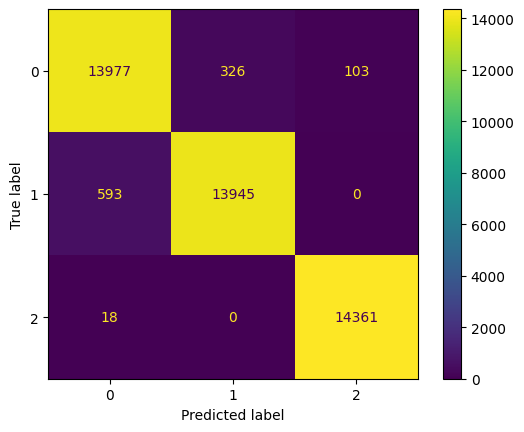

In [ ]:
y_test_int32 = y_test.astype('int32')
y_pred_int32 = y_pred_rf.astype('int32')
from cuml.metrics import confusion_matrix as cucm
# Compute confusion matrix
conf_matrix = cucm(y_test_int32, y_pred_int32)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix.get(),
display_labels=model.classes_.to_pandas())

disp.plot()

Results

In [ ]:
Ascore_df = acc_score.sort_values(by = 'cuml_accuracy', ascending = False)
Ascore_df

,Algorithm,cuml_accuracy,cuml_r2_score
3,XGBoost,0.979988,0.961959
7,Random Forest,0.975994,0.951259
2,SVM,0.971055,0.923502
5,Decision Tree,0.970408,0.950669
4,ANN,0.969508,0.906479
1,KNN,0.966715,0.890394
0,LogisticRegression,0.958959,0.898732
6,Gaussian Naive Bayes,0.926252,0.871183


In [ ]:
Rscore_df = acc_score.sort_values(by = 'cuml_r2_score', ascending = False)
Rscore_df

,Algorithm,cuml_accuracy,cuml_r2_score
3,XGBoost,0.979988,0.961959
7,Random Forest,0.975994,0.951259
5,Decision Tree,0.970408,0.950669
2,SVM,0.971055,0.923502
4,ANN,0.969508,0.906479
0,LogisticRegression,0.958959,0.898732
1,KNN,0.966715,0.890394
6,Gaussian Naive Bayes,0.926252,0.871183


In [ ]:
#So according to both the parameters: XGBOOST IS TOP PERFORMING MODEL

Data Visualisation

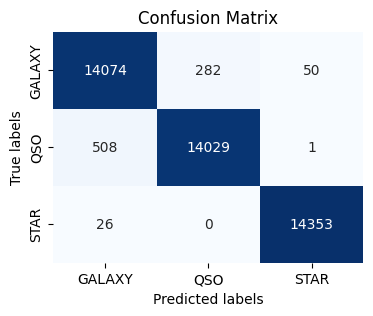

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = cucm(y_test_int32_xg, y_pred_int32_xg)
class_names=['GALAXY','QSO','STAR']

# Plot confusion matrix as a heatmap
plt.figure(figsize=(4,3))
sns.heatmap(conf_matrix.get(), annot=True, fmt="d", cmap="Blues", cbar=False,xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

<Axes: xlabel='Algorithm'>

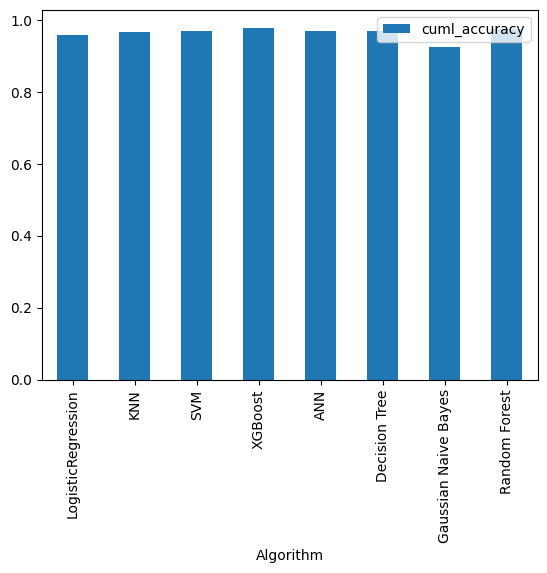

In [ ]:
acc_score.to_pandas().plot(x="Algorithm", y="cuml_accuracy", kind="bar")

<Axes: xlabel='Algorithm'>

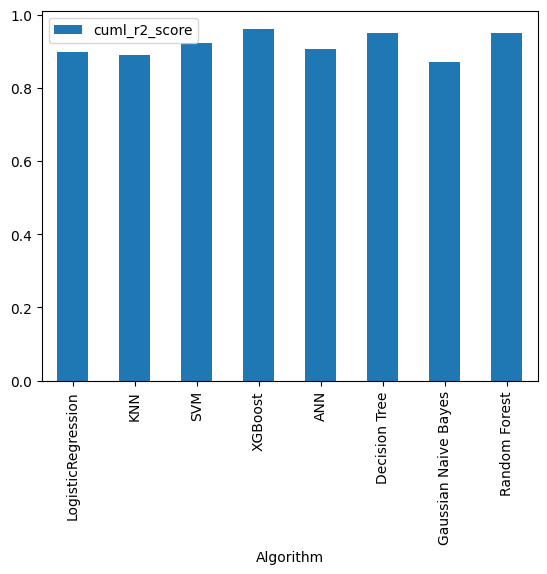

In [ ]:
acc_score.to_pandas().plot(x="Algorithm", y="cuml_r2_score", kind="bar")